# Traffic Signs Detection with YOLO v3, OpenCV and Keras

# 📥 Importing needed libraries

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import time
from timeit import default_timer as timer
import matplotlib.pyplot as plt
import pickle

from keras.models import load_model

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('../input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

print(os.listdir('../input'))

# Any results we write to the current directory are saved as output


Using TensorFlow backend.


['traffic-signs-preprocessed', 'traffic-signs-classification-with-cnn', 'trainedtrafficsignsdetectorbasedonyolov3', 'videos-for-testing', 'traffic-signs-dataset-in-yolo-format']


# 📂 Loading *labels*

In [2]:
# Reading csv file with labels' names
# Loading two columns [0, 1] into Pandas dataFrame
labels = pd.read_csv('/kaggle/input/traffic-signs-preprocessed/label_names.csv')

# Check point
# Showing first 5 rows from the dataFrame
print(labels.head())
print()

# To locate by class number use one of the following
# ***.iloc[0][1] - returns element on the 0 column and 1 row
print(labels.iloc[0][1])  # Speed limit (20km/h)
# ***['SignName'][1] - returns element on the column with name 'SignName' and 1 row
print(labels['SignName'][1]) # Speed limit (30km/h)


   ClassId              SignName
0        0  Speed limit (20km/h)
1        1  Speed limit (30km/h)
2        2  Speed limit (50km/h)
3        3  Speed limit (60km/h)
4        4  Speed limit (70km/h)

Speed limit (20km/h)
Speed limit (30km/h)


# 📂 Loading trained Keras CNN model for Classification

In [3]:
# Loading trained CNN model to use it later when classifying from 4 groups into one of 43 classes
model = load_model('/kaggle/input/traffic-signs-classification-with-cnn/model-23x23.h5')

# Loading mean image to use for preprocessing further
# Opening file for reading in binary mode
with open('/kaggle/input/traffic-signs-preprocessed/mean_image_rgb.pickle', 'rb') as f:
    mean = pickle.load(f, encoding='latin1')  # dictionary type
    
print(mean['mean_image_rgb'].shape)  # (3, 32, 32)


(3, 32, 32)


## Loading *trained weights* and *cfg file* into the Network

In [4]:
# Trained weights can be found in the course mentioned above
path_to_weights = '/kaggle/input/trainedtrafficsignsdetectorbasedonyolov3/yolov3_ts_train_5000.weights'
path_to_cfg = '/kaggle/input/traffic-signs-dataset-in-yolo-format/yolov3_ts_train.cfg'

# Loading trained YOLO v3 weights and cfg configuration file by 'dnn' library from OpenCV
network = cv2.dnn.readNetFromDarknet(path_to_cfg, path_to_weights)

# To use with GPU
network.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
network.setPreferableTarget(cv2.dnn.DNN_TARGET_OPENCL_FP16)


## Getting *output layers* where detections are made

In [5]:
# Getting names of all YOLO v3 layers
layers_all = network.getLayerNames()

# Check point
# print(layers_all)

# Getting only detection YOLO v3 layers that are 82, 94 and 106
layers_names_output = [layers_all[i[0] - 1] for i in network.getUnconnectedOutLayers()]

# Check point
print()
print(layers_names_output)  # ['yolo_82', 'yolo_94', 'yolo_106']



['yolo_82', 'yolo_94', 'yolo_106']


## Setting *probability*, *threshold* and *colour* for bounding boxes

In [6]:
# Minimum probability to eliminate weak detections
probability_minimum = 0.2

# Setting threshold to filtering weak bounding boxes by non-maximum suppression
threshold = 0.2

# Generating colours for bounding boxes
# randint(low, high=None, size=None, dtype='l')
colours = np.random.randint(0, 255, size=(len(labels), 3), dtype='uint8')

# Check point
print(type(colours))  # <class 'numpy.ndarray'>
print(colours.shape)  # (43, 3)
print(colours[0])  # [25  65 200]


<class 'numpy.ndarray'>
(43, 3)
[ 20 223 184]


# 🎬 Reading input video

In [7]:
# Reading video from a file by VideoCapture object
video = cv2.VideoCapture('/kaggle/input/traffic-signs-dataset-in-yolo-format/traffic-sign-to-test.mp4')
# video = cv2.VideoCapture('../input/videofortesting/ts_video_1.mp4')
#video = cv2.VideoCapture('../input/videofortesting/ts_video_6.mp4')

# Writer that will be used to write processed frames
writer = None

# Variables for spatial dimensions of the frames
h, w = None, None


# ➿ Processing frames in the loop

In [8]:
%matplotlib inline

# Setting default size of plots
plt.rcParams['figure.figsize'] = (3, 3)

# Variable for counting total amount of frames
f = 0

# Variable for counting total processing time
t = 0

# Catching frames in the loop
while True:
    # Capturing frames one-by-one
    ret, frame = video.read()

    # If the frame was not retrieved
    if not ret:
        break
       
    # Getting spatial dimensions of the frame for the first time
    if w is None or h is None:
        # Slicing two elements from tuple
        h, w = frame.shape[:2]

    # Blob from current frame
    blob = cv2.dnn.blobFromImage(frame, 1 / 255.0, (416, 416), swapRB=True, crop=False)

    # Forward pass with blob through output layers
    network.setInput(blob)
    start = time.time()
    output_from_network = network.forward(layers_names_output)
    end = time.time()

    # Increasing counters
    f += 1
    t += end - start

    # Spent time for current frame
    print('Frame number {0} took {1:.5f} seconds'.format(f, end - start))

    # Lists for detected bounding boxes, confidences and class's number
    bounding_boxes = []
    confidences = []
    class_numbers = []

    # Going through all output layers after feed forward pass
    for result in output_from_network:
        # Going through all detections from current output layer
        for detected_objects in result:
            # Getting 80 classes' probabilities for current detected object
            scores = detected_objects[5:]
            # Getting index of the class with the maximum value of probability
            class_current = np.argmax(scores)
            # Getting value of probability for defined class
            confidence_current = scores[class_current]

            # Eliminating weak predictions by minimum probability
            if confidence_current > probability_minimum:
                # Scaling bounding box coordinates to the initial frame size
                box_current = detected_objects[0:4] * np.array([w, h, w, h])

                # Getting top left corner coordinates
                x_center, y_center, box_width, box_height = box_current
                x_min = int(x_center - (box_width / 2))
                y_min = int(y_center - (box_height / 2))

                # Adding results into prepared lists
                bounding_boxes.append([x_min, y_min, int(box_width), int(box_height)])
                confidences.append(float(confidence_current))
                class_numbers.append(class_current)
                

    # Implementing non-maximum suppression of given bounding boxes
    results = cv2.dnn.NMSBoxes(bounding_boxes, confidences, probability_minimum, threshold)

    # Checking if there is any detected object been left
    if len(results) > 0:
        # Going through indexes of results
        for i in results.flatten():
            # Bounding box coordinates, its width and height
            x_min, y_min = bounding_boxes[i][0], bounding_boxes[i][1]
            box_width, box_height = bounding_boxes[i][2], bounding_boxes[i][3]
            
            
            # Cut fragment with Traffic Sign
            c_ts = frame[y_min:y_min+int(box_height), x_min:x_min+int(box_width), :]
            # print(c_ts.shape)
            
            if c_ts.shape[:1] == (0,) or c_ts.shape[1:2] == (0,):
                pass
            else:
                # Getting preprocessed blob with Traffic Sign of needed shape
                blob_ts = cv2.dnn.blobFromImage(c_ts, 1 / 255.0, size=(32, 32), swapRB=True, crop=False)
                blob_ts[0] = blob_ts[0, :, :, :] - mean['mean_image_rgb']
                blob_ts = blob_ts.transpose(0, 2, 3, 1)
                # plt.imshow(blob_ts[0, :, :, :])
                # plt.show()

                # Feeding to the Keras CNN model to get predicted label among 43 classes
                scores = model.predict(blob_ts)

                # Scores is given for image with 43 numbers of predictions for each class
                # Getting only one class with maximum value
                prediction = np.argmax(scores)
                # print(labels['SignName'][prediction])


                # Colour for current bounding box
                colour_box_current = colours[class_numbers[i]].tolist()

                # Drawing bounding box on the original current frame
                cv2.rectangle(frame, (x_min, y_min),
                              (x_min + box_width, y_min + box_height),
                              colour_box_current, 2)

                # Preparing text with label and confidence for current bounding box
                text_box_current = '{}: {:.4f}'.format(labels['SignName'][prediction],
                                                       confidences[i])

                # Putting text with label and confidence on the original image
                cv2.putText(frame, text_box_current, (x_min, y_min - 5),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, colour_box_current, 2)


    # Initializing writer only once
    if writer is None:
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')

        # Writing current processed frame into the video file
        writer = cv2.VideoWriter('result.mp4', fourcc, 25,
                                 (frame.shape[1], frame.shape[0]), True)

    # Write processed current frame to the file
    writer.write(frame)


# Releasing video reader and writer
video.release()
writer.release()


Frame number 1 took 1.52073 seconds
Frame number 2 took 1.07227 seconds
Frame number 3 took 1.06609 seconds
Frame number 4 took 1.12718 seconds
Frame number 5 took 1.07708 seconds
Frame number 6 took 1.07527 seconds
Frame number 7 took 1.07485 seconds
Frame number 8 took 1.07127 seconds
Frame number 9 took 1.06989 seconds
Frame number 10 took 1.06905 seconds
Frame number 11 took 1.07707 seconds
Frame number 12 took 1.12868 seconds
Frame number 13 took 1.07035 seconds
Frame number 14 took 1.07224 seconds
Frame number 15 took 1.07032 seconds
Frame number 16 took 1.06933 seconds
Frame number 17 took 1.07584 seconds
Frame number 18 took 1.06759 seconds
Frame number 19 took 1.46597 seconds
Frame number 20 took 1.21541 seconds
Frame number 21 took 1.07293 seconds
Frame number 22 took 1.07291 seconds
Frame number 23 took 1.07700 seconds
Frame number 24 took 1.07080 seconds
Frame number 25 took 1.07876 seconds
Frame number 26 took 1.06969 seconds
Frame number 27 took 1.07245 seconds
Frame numb

## 🏁 FPS results

In [9]:
print('Total number of frames', f)
print('Total amount of time {:.5f} seconds'.format(t))
print('FPS:', round((f / t), 1))


Total number of frames 56
Total amount of time 62.03354 seconds
FPS: 0.9


In [10]:
# Saving locally without committing
from IPython.display import FileLink

FileLink('result.mp4')


/kaggle/working/result.mp4

#  Reading input images

In [24]:
image_BGR = cv2.imread('/kaggle/input/traffic-signs-dataset-in-yolo-format/ts/ts/00006.jpg')
#image_BGR = cv2.imread('/kaggle/working/result.mp4')

# Check point
# Showing image shape
print('Image shape:', image_BGR.shape)  # tuple of (731, 1092, 3)

# Getting spatial dimension of input image
h, w = image_BGR.shape[:2]  # Slicing from tuple only first two elements

# Check point
# Showing height an width of image
print('Image height={0} and width={1}'.format(h, w))  # 731 1092

Image shape: (800, 1360, 3)
Image height=800 and width=1360


In [17]:
import pickle

# Load the pickle file
with open('/kaggle/input/traffic-signs-preprocessed/test.pickle', 'rb') as f:
    data = pickle.load(f)

# Print the keys of the dictionary to understand its structure
print("Keys in the pickle file:", data.keys())

# Access the image data
# This is just an example, you'll need to replace 'image_key' with the actual key
# For example:
# image_BGR = data['image_key']
# print('Image shape:', image_BGR.shape)

# If there are multiple images, you might need to iterate over them
# For example, if the images are in a list under a key:
# for image_BGR in data['images_list']:
#     print('Image shape:', image_BGR.shape)

Keys in the pickle file: dict_keys(['sizes', 'coords', 'features', 'labels'])


#  Processing single image

In [25]:
# Variable for counting total processing time
t = 0

# Blob from current frame
blob = cv2.dnn.blobFromImage(image_BGR, 1 / 255.0, (416, 416), swapRB=True, crop=False)

# Forward pass with blob through output layers
network.setInput(blob)
start = time.time()
output_from_network = network.forward(layers_names_output)
end = time.time()

# Time
t += end - start
print('Total amount of time {:.5f} seconds'.format(t))

# Lists for detected bounding boxes, confidences and class's number
bounding_boxes = []
confidences = []
class_numbers = []

# Going through all output layers after feed forward pass
for result in output_from_network:
    # Going through all detections from current output layer
    for detected_objects in result:
        # Getting 80 classes' probabilities for current detected object
        scores = detected_objects[5:]
        # Getting index of the class with the maximum value of probability
        class_current = np.argmax(scores)
        # Getting value of probability for defined class
        confidence_current = scores[class_current]

        # Eliminating weak predictions by minimum probability
        if confidence_current > probability_minimum:
            # Scaling bounding box coordinates to the initial frame size
            box_current = detected_objects[0:4] * np.array([w, h, w, h])

            # Getting top left corner coordinates
            x_center, y_center, box_width, box_height = box_current
            x_min = int(x_center - (box_width / 2))
            y_min = int(y_center - (box_height / 2))

            # Adding results into prepared lists
            bounding_boxes.append([x_min, y_min, int(box_width), int(box_height)])
            confidences.append(float(confidence_current))
            class_numbers.append(class_current)
                

# Implementing non-maximum suppression of given bounding boxes
results = cv2.dnn.NMSBoxes(bounding_boxes, confidences, probability_minimum, threshold)

# Checking if there is any detected object been left
if len(results) > 0:
    # Going through indexes of results
    for i in results.flatten():
        # Bounding box coordinates, its width and height
        x_min, y_min = bounding_boxes[i][0], bounding_boxes[i][1]
        box_width, box_height = bounding_boxes[i][2], bounding_boxes[i][3]
            
            
        # Cut fragment with Traffic Sign
        c_ts = image_BGR[y_min:y_min+int(box_height), x_min:x_min+int(box_width), :]
        # print(c_ts.shape)
            
        if c_ts.shape[:1] == (0,) or c_ts.shape[1:2] == (0,):
            pass
        else:
            # Getting preprocessed blob with Traffic Sign of needed shape
            blob_ts = cv2.dnn.blobFromImage(c_ts, 1 / 255.0, size=(32, 32), swapRB=True, crop=False)
            blob_ts[0] = blob_ts[0, :, :, :] - mean['mean_image_rgb']
            blob_ts = blob_ts.transpose(0, 2, 3, 1)
            # plt.imshow(blob_ts[0, :, :, :])
            # plt.show()

            # Feeding to the Keras CNN model to get predicted label among 43 classes
            scores = model.predict(blob_ts)

            # Scores is given for image with 43 numbers of predictions for each class
            # Getting only one class with maximum value
            prediction = np.argmax(scores)
            print(labels['SignName'][prediction])


            # Colour for current bounding box
            colour_box_current = colours[class_numbers[i]].tolist()
            
            # Green BGR
            colour_box_current = [0, 255, 61]
            
            # Yellow BGR
#             colour_box_current = [0, 255, 255]

            # Drawing bounding box on the original current frame
            cv2.rectangle(image_BGR, (x_min, y_min),
                              (x_min + box_width, y_min + box_height),
                              colour_box_current, 6)
            
            if prediction == 5:
                # Preparing text with label and confidence for current bounding box
                text_box_current = '{}: {:.4f}'.format('Speed limit 60', confidences[i])

                # Putting text with label and confidence on the original image
                cv2.putText(image_BGR, text_box_current, (x_min - 110, y_min - 10),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.9, colour_box_current, 2)
                
            elif prediction == 9:            
                # Preparing text with label and confidence for current bounding box
                text_box_current = '{}: {:.4f}'.format('No overtaking', confidences[i])

                # Putting text with label and confidence on the original image
                cv2.putText(image_BGR, text_box_current, (x_min - 110, y_min + box_height + 30),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.9, colour_box_current, 2)

                
                
# Saving image
cv2.imwrite('result.png', image_BGR)


Total amount of time 1.07365 seconds
Speed limit (50km/h)


True

# Showing processed image

Image shape: (800, 1360, 3)
Image height=800 and width=1360


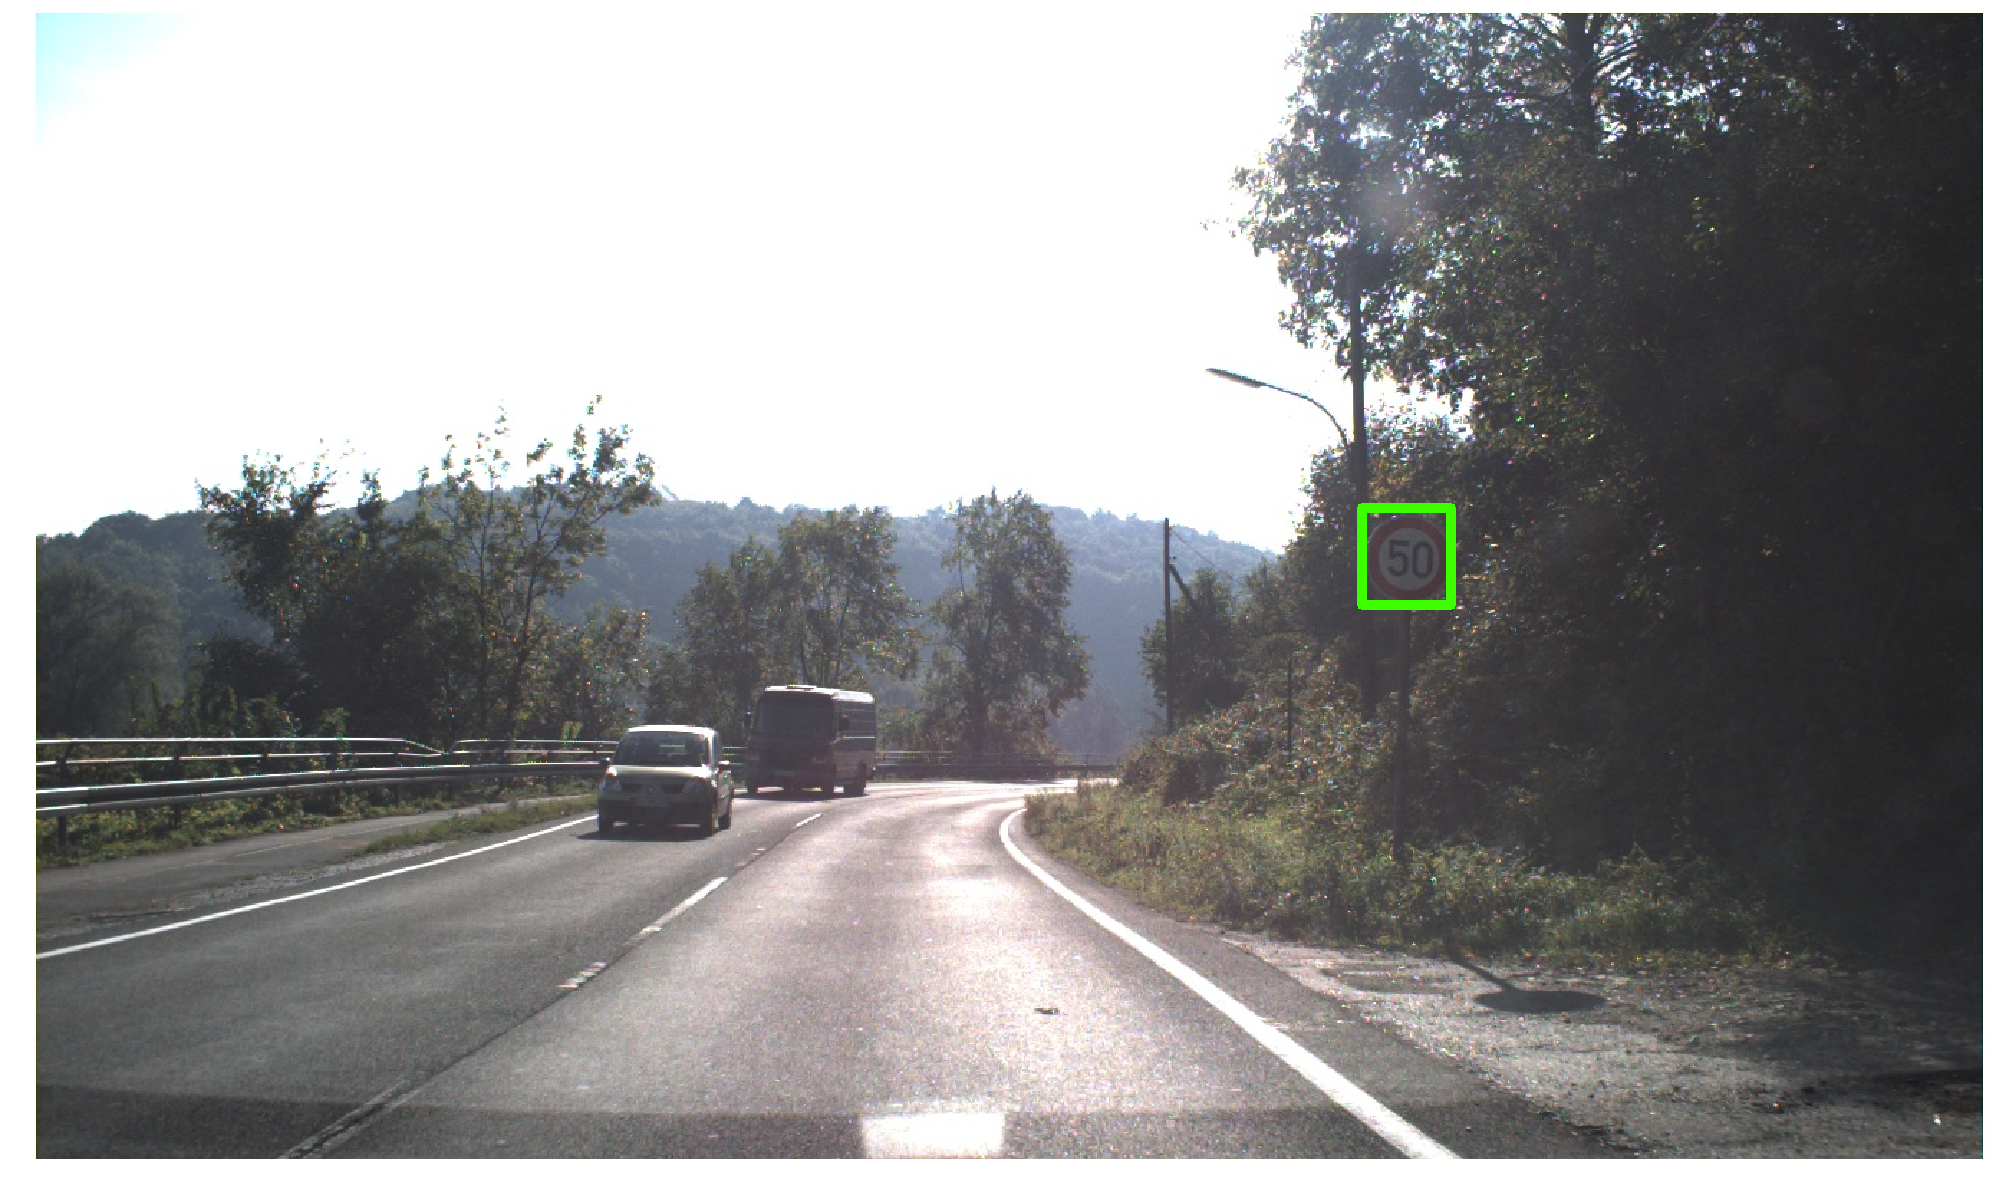

In [26]:
%matplotlib inline

plt.rcParams['figure.figsize'] = (35.0, 35.0) # Setting default size of plots

image_BGR = cv2.imread('/kaggle/working/result.png')

# Showing image shape
print('Image shape:', image_BGR.shape)  # tuple of (800, 1360, 3)

# Getting spatial dimension of input image
h, w = image_BGR.shape[:2]  # Slicing from tuple only first two elements

# Showing height an width of image
print('Image height={0} and width={1}'.format(h, w))  # 800 1360

plt.imshow(cv2.cvtColor(image_BGR, cv2.COLOR_BGR2RGB))
plt.axis('off')
# plt.title('Keras Visualization', fontsize=18)

# Showing the plot
plt.show()

plt.close()


In [27]:
# Saving locally without committing
from IPython.display import FileLink

FileLink('result.png')


/kaggle/working/result.png

# Example of the result

![](https://www.googleapis.com/download/storage/v1/b/kaggle-user-content/o/inbox%2F3400968%2Fa57f58b38e3caab6fbf72169895f5074%2Fresult.gif?generation=1585955236302060&alt=media)